In [1]:
import sys

sys.path.append('../')
import pandas as pd
import numpy as np
from grail_metabolism.utils.preparation import MolFrame
from grail_metabolism.model.generator import Generator
from tqdm.auto import tqdm
import pickle as pkl

ATTENTION: RXNMapper is not installed. Please install it first if you want to create your own set of rules.
ATTENTION: you use incorrect for rxnmapper version of rdkit


In [ ]:
uspto = pkl.load(open('../notebooks/uspto.pkl', 'rb'))

In [2]:
from grail_metabolism.model.generator import Generator

In [10]:
mol_structs = {}
for _, row in tqdm(uspto.iterrows(), total=len(uspto)):
    mol_structs[row['sub']] = row['sub_mol']
    mol_structs[row['prod']] = row['prod_mol']
uspto['real'] = np.ones(len(uspto)).astype(int)

  0%|          | 0/1798556 [00:00<?, ?it/s]

In [11]:
uspto_frame = MolFrame(uspto, mol_structs=mol_structs, standartize=False)

Processing reactions:   0%|          | 0/573055 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [2]:
with open('../grail_metabolism/data/uspto_extr.txt') as f:
    uspto_rules = f.read().splitlines()

In [3]:
from collections import Counter

In [4]:
count = Counter(uspto_rules)

In [5]:
top500 = [key for key, _ in count.most_common(500)]

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem

In [7]:
def label_uspto(frame: MolFrame, rules: list[str]):
    labels = {}
    for smi in tqdm(frame.map):
        mol = Chem.MolFromSmiles(smi)
        labels[smi] = np.zeros(len(rules), dtype=int)
        for i, rule in enumerate(rules):
            rxn = AllChem.ReactionFromSmarts(rule)
            if len(rxn.RunReactants((mol,))) != 0:
                labels[smi][i] = 1
    return labels

In [11]:
labels = label_uspto(uspto_frame, top500)

  0%|          | 0/573055 [00:00<?, ?it/s]

In [12]:
with open('../grail_metabolism/data/labels.pkl', 'wb') as f:
    pkl.dump(labels, f)

In [8]:
with open('../grail_metabolism/data/labels.pkl', 'rb') as f:
    labels = pkl.load(f)

In [3]:
import torch
from torch.nn import Module, Sequential, ReLU, Linear, Bilinear, MultiheadAttention, BatchNorm1d, Dropout, init, Sigmoid
from torch.nn.functional import dropout
from torch_geometric.nn import GATv2Conv, global_mean_pool
from torch_geometric.data import Batch, Data
from torch_geometric.loader import DataLoader
from torch_geometric import nn
from grail_metabolism.utils.transform import from_rule, from_rdmol
from grail_metabolism.model.train_model import AsymmetricBCELoss
from sklearn.impute import SimpleImputer

In [9]:
singles = {}
ats = '../grail_metabolism/data/pca_ats_single.pkl'
bonds = '../grail_metabolism/data/pca_bonds_single.pkl'
with open(ats, 'rb') as file:
    pca_x = pkl.load(file)
with open(bonds, 'rb') as file:
    pca_b = pkl.load(file)
for smi in tqdm(labels):
    sub_mol = from_rdmol(Chem.MolFromSmiles(smi))
    for i in range(len(sub_mol.x)):
        for j in range(len(sub_mol.x[i])):
            if sub_mol.x[i][j] == float('inf'):
                sub_mol.x[i][j] = 0
    sub_mol.x = torch.tensor(SimpleImputer(missing_values=np.nan,
                                  strategy='constant',
                                  fill_value=0).fit_transform(sub_mol.x))
    sub_mol.x = torch.tensor(pca_x.transform(sub_mol.x))
    try:
        sub_mol.edge_attr = torch.tensor(pca_b.transform(sub_mol.edge_attr))
        singles[smi] = sub_mol
    except ValueError:
        print('Some issue happened with this molecule:')
        print(smi)

  0%|          | 0/573055 [00:00<?, ?it/s]

In [10]:
rule_dict = {rule: from_rule(rule) for rule in tqdm(top500)}

  0%|          | 0/500 [00:00<?, ?it/s]

In [11]:
model = Generator(rule_dict, 10, 6)

In [12]:
import matplotlib.pyplot as plt

In [17]:
with open('../grail_metabolism/data/singles.pkl', 'wb') as f:
    pkl.dump(singles, f, protocol=pkl.HIGHEST_PROTOCOL)

In [13]:
with open('../grail_metabolism/data/singles.pkl', 'rb') as f:
    singles = pkl.load(f)

  0%|          | 0/573055 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 2970.6338982582092
Loss: 2168.533721268177
Loss: 2070.1511510312557
Loss: 1989.6682936549187
Loss: 1881.1818253397942
Loss: 1752.3031359016895
Loss: 1655.211161762476
Loss: 1578.061034977436
Loss: 1489.4850628077984
Loss: 1401.463714942336
Loss: 1335.3646697103977
Loss: 1278.1936569660902
Loss: 1235.1456415504217
Loss: 1200.0471871942282
Loss: 1167.6519188135862
Loss: 1140.0890835225582
Loss: 1114.0230617970228
Loss: 1089.2277823090553
Loss: 1065.734705671668
Loss: 1042.0216889232397
Loss: 1024.0820849984884
Loss: 1003.7830637842417
Loss: 986.6772526204586
Loss: 967.0037065595388
Loss: 954.4880864620209
Loss: 939.0083386749029
Loss: 925.9368975013494
Loss: 912.594393491745
Loss: 897.4519116580486
Loss: 886.0610184520483
Loss: 877.5556546896696
Loss: 864.762950733304
Loss: 856.0198929458857
Loss: 846.7224649041891
Loss: 839.9371417909861
Loss: 830.5541666448116
Loss: 824.7957972735167
Loss: 816.5689986050129
Loss: 808.7813026532531
Loss: 802.8226219713688
Loss: 793.669002763927
Lo

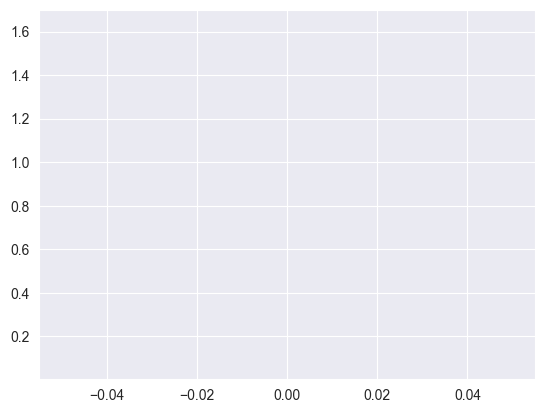

In [14]:
criterion = AsymmetricBCELoss(gamma=5)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, betas=(0.9, 0.99), weight_decay=1e-10)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(  # Адаптивный шедулер
    optimizer, mode='min', factor=0.5, patience=3
)

train_loader = []
vecs = labels

for i, substrate in enumerate(tqdm(singles)):
    datum = singles[substrate]
    # Преобразуем целевые метки в форму [num_rules]
    datum.y = torch.tensor(vecs[substrate], dtype=torch.float32)
    train_loader.append(datum)

train_loader = DataLoader(train_loader, batch_size=128, shuffle=True)

history = []
for _ in tqdm(range(100)):
    model.train()
    epoch_loss = 0
    best_loss = float('inf')
    for batch in train_loader:
        out = model(batch)

        # Правильное преобразование формы целевых меток
        target = batch.y.view(out.shape[0], -1)  # [batch_size, num_rules]

        # Проверка размерностей
        assert out.shape == target.shape, \
            f"Shape mismatch: out {out.shape} vs target {target.shape}"

        loss = criterion(out, target)
        plt.plot(loss.item())
        history.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        epoch_loss += loss.item()
    print(f'Loss: {epoch_loss}')
    scheduler.step(epoch_loss)

    scheduler.step(epoch_loss)
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(model.state_dict(), 'best_pretrained_generator.pth')

In [3]:
import torch

In [6]:
with open('../grail_metabolism/data/smirks.txt') as f:
    rules = f.read().splitlines()

In [7]:
from grail_metabolism.utils.transform import from_rule

In [8]:
rule_dict = {rule: from_rule(rule) for rule in rules}

In [9]:
generator = Generator(rule_dict, 10, 6)

In [10]:
state_dt = torch.load('../grail_metabolism/best_pretrained_generator.pth')

In [11]:
state_dt['final_proj.weight'] = torch.nn.init.xavier_uniform_(torch.zeros(474, 100))

In [12]:
state_dt['final_proj.bias'] = torch.zeros(474)

In [13]:
generator.load_state_dict(state_dt)

<All keys matched successfully>

In [14]:
ct = 0
for child in generator.children():
    ct += 1
    if ct < 3:
        for param in child.parameters():
            param.requires_grad = False

In [15]:
import pickle as pkl
with open('../grail_metabolism/data/train_labelled.pkl', 'rb') as f:
    train = pkl.load(f)

Starting DataLoaders generation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss 96.23803400993347
Loss 82.9944314956665
Loss 71.63479506969452
Loss 62.61836552619934
Loss 54.8427671790123
Loss 48.114592254161835
Loss 41.97697740793228
Loss 36.189572632312775
Loss 30.801946938037872
Loss 25.88821032643318
Loss 21.47743946313858
Loss 17.513809099793434
Loss 14.031209826469421
Loss 11.123308554291725
Loss 8.702456466853619
Loss 6.754078574478626
Loss 5.24439138174057
Loss 4.123270723968744
Loss 3.3134894259274006
Loss 2.7464431636035442
Loss 2.3767175059765577
Loss 2.0955868288874626
Loss 1.9304786510765553
Loss 1.7984566446393728
Loss 1.6991457492113113
Loss 1.629593126475811
Loss 1.6025165058672428
Loss 1.5671136397868395
Loss 1.518072048202157
Loss 1.5039092469960451
Loss 1.475499004125595
Loss 1.4570500534027815
Loss 1.4415014535188675
Loss 1.4279817026108503
Loss 1.4255452184006572
Loss 1.4189350036904216
Loss 1.408639551140368
Loss 1.4007699768990278
Loss 1.4131390461698174
Loss 1.3901302656158805
Loss 1.397983618080616
Loss 1.3818124867975712
Loss 1.37728

KeyboardInterrupt: 

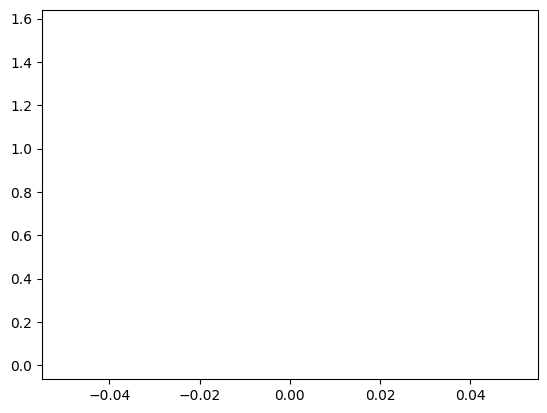

In [16]:
generator.fit(train)

In [ ]:
generator.generate('c1ccccc1')[0]